# AR5IR RCMIP

Here we perform the AR5IR runs for RCMIP. This notebook shows how the OpenSCM library should 'feel' to the end user. We're not at that point yet and will need a major re-write to get it workable, but this at least shows where we're going.

## Imports

In [1]:
import json
import os.path

import numpy as np
import pandas as pd
import tqdm.notebook
from scmdata import df_append, ScmDataFrame

<IPython.core.display.Javascript object>

## Models

In [2]:
class AR5IRBase():
    def __init__(self):
        pass

    def run(self, inputs, run_params, outputs=None):
        """
        inputs : scmdata.ScmDataFrame
        
        run_params : dict
        """
        if outputs is not None and outputs != ["Surface Temperature"]:
            print(outputs)
            raise ValueError("{} only calculates Surface Temperature".format(self.name))
    
        co2_concentrations_scmdf = inputs.filter(
            variable="Atmospheric Concentrations|CO2",
            region="World",
            unit="ppm",
        )
        
        scenario = co2_concentrations_scmdf.get_unique_meta("scenario", no_duplicates=True)
        model = co2_concentrations_scmdf.get_unique_meta("model", no_duplicates=True)
        time = co2_concentrations_scmdf["time"]
        
        self.co2_concentrations = co2_concentrations_scmdf.timeseries().values.squeeze()
        non_co2_radiative_forcing_scmdf = inputs.filter(
            variable="Effective Radiative Forcing|Non-CO2",
            region="World",
            unit="W/m\^2",
        )
        if non_co2_radiative_forcing_scmdf.timeseries().empty:
            self.non_co2_radiative_forcing = np.zeros_like(self.co2_concentrations)
            
            non_co2_radiative_forcing_scmdf = self._create_out_scmdf(
                "Effective Radiative Forcing|Non-CO2",
                "W/m^2",
                np.zeros_like(self.co2_concentrations),
                co2_concentrations_scmdf,
            )
        else:
            self.non_co2_radiative_forcing = non_co2_radiative_forcing_scmdf.timeseries().values.squeeze()
            
        assert self.co2_concentrations.shape == self.non_co2_radiative_forcing.shape, (
            "{}, {}".format(self.co2_concentrations.shape, self.non_co2_radiative_forcing.shape)
        )
        for kwarg, value in run_params.items():
            setattr(self, kwarg, value)

        self.calculate_co2_radiative_forcing()
        self.calculate_temperatures()
        
        out_temperatures = self._create_out_scmdf(
            "Surface Air Temperature Change",
            "K",
            self.temperatures,
            co2_concentrations_scmdf,
        )
        
        out_co2_forcing = self._create_out_scmdf(
            "Effective Radiative Forcing|CO2",
            "W/m^2",
            self.co2_radiative_forcing,
            co2_concentrations_scmdf,
        )
        
        out = df_append([
            co2_concentrations_scmdf, 
            non_co2_radiative_forcing_scmdf, 
            out_temperatures, 
            out_co2_forcing,
        ])
        out.set_meta(self.name, "climatemodel")

        return out
    
    def _create_out_scmdf(self, variable, unit, values, base_scmdf):
        out_scmdf = base_scmdf.timeseries()
        out_scmdf.iloc[:, :] = values
        out_scmdf = out_scmdf.reset_index()
        out_scmdf["variable"] = variable
        out_scmdf["unit"] = unit
        
        return ScmDataFrame(out_scmdf)

    def calculate_co2_radiative_forcing(self):
        self.co2_radiative_forcing = (
            self.f2x / np.log(2) * np.log(self.co2_concentrations / self.co2_pi)
        )

In [3]:
class AR5IR2Box(AR5IRBase):
    """
    Quick implementation of AR5IR in a CO2-conc plus non-CO2 ERF driven run mode
    
    Based on:
    F = F2x / ln(2) * ln(C / C_0)
    
    where F2x is RF due to doubling CO2, C is atmospheric conc. of CO2 
    and C_0 is PI conc. of CO2
    
    c_j F = \\Delta T + d_j d \\Delta T / dt 
    
    with j=2 and all terms as in IPCC AR5 WG1 eq. 8.SM.13
    
    Inputs should all be on an annual timestep (no checks are done for
    this...)
    """

    name = "ar5ir2box"

    co2_pi = 278
    f2x = 3.74
    c1 = 0.631
    d1 = 8.4
    c2 = 0.429
    d2 = 409.5

    def calculate_temperatures(self):
        """
        This is a bit fiddly as we have to return mid year values
        """
        c = np.array([self.c1, self.c2])
        d = np.array([self.d1, self.d2])
        temp_perturbations = np.nan * np.zeros((len(self.co2_concentrations) + 1, 2))
        temp_perturbations[0, :] = 0

        factor = 1 - 1 / d
        total_forcing = self.co2_radiative_forcing + self.non_co2_radiative_forcing
        temp = total_forcing[:, np.newaxis] * c / d
        for i in range(1, temp_perturbations.shape[0]):
            temp_perturbations[i, :] = (
                temp_perturbations[i - 1] * factor + temp[i - 1]
            )  # assuming one year timestep

        temp_perturbations_midyear = (
            temp_perturbations[:-1, :] + temp_perturbations[1:, :]
        ) / 2
        self.temperatures = temp_perturbations_midyear.sum(axis=1)

In [4]:
class AR5IR3Box(AR5IRBase):
    """
    Quick implementation of AR5IR with 3 boxes in a CO2-conc plus non-CO2 ERF driven run mode
    
    Based on:
    F = F2x / ln(2) * ln(C / C_0)
    
    where F2x is RF due to doubling CO2, C is atmospheric conc. of CO2 
    and C_0 is PI conc. of CO2
    
    c_j F = \\Delta T + d_j d \\Delta T / dt 
    
    with j=3 and all terms as in IPCC AR5 WG1 eq. 8.SM.13
    
    Inputs should all be on an annual timestep (no checks are done for
    this...)
    """

    name = "ar5ir3box"

    co2_pi = 278
    f2x = 3.74
    c1 = 0.631
    d1 = 8.4
    c2 = 0.429
    d2 = 409.5
    c3 = 0.2
    d3 = 1

    def calculate_temperatures(self):
        """
        This is a bit fiddly as we have to return mid year values
        """
        c = np.array([self.c1, self.c2, self.c3])
        d = np.array([self.d1, self.d2, self.d3])
        temp_perturbations = np.nan * np.zeros((len(self.co2_concentrations) + 1, 3))
        temp_perturbations[0, :] = 0

        factor = 1 - 1 / d
        total_forcing = self.co2_radiative_forcing + self.non_co2_radiative_forcing
        temp = total_forcing[:, np.newaxis] * c / d
        for i in range(1, temp_perturbations.shape[0]):
            temp_perturbations[i, :] = (
                temp_perturbations[i - 1] * factor + temp[i - 1]
            )  # assuming one year timestep

        temp_perturbations_midyear = (
            temp_perturbations[:-1, :] + temp_perturbations[1:, :]
        ) / 2
        self.temperatures = temp_perturbations_midyear.sum(axis=1)

## RCMIP data

In [5]:
RCMIP_CONCS_FILE = os.path.join(
    "rcmip-concentrations-annual-means-v3-1-0.csv"
)

RCMIP_FORCING_FILE = os.path.join(
    "rcmip-radiative-forcing-annual-means-v3-1-0.csv"
)

In [6]:
rcmip_data = df_append([RCMIP_CONCS_FILE, RCMIP_FORCING_FILE])
rcmip_data.head()

time                                                                                                    1700-01-01 00:00:00  \
model       scenario region                    variable                       unit activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World                     Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   

time                                                                                                    1701-01-01 00:00:00  \
model       scenario region                    variable                       unit activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World                     Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   

time                                                                                                    1702-01-01 00:00:00  \
model       scenario region                    variable                       unit activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World                     Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   

time                                                                                                    1703-01-01 00:00:00  \
model       scenario region                    variable                       unit activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World                     Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   

time                                                                                                    1704-01-01 00:00:00  \
model       scenario region                    variable                       unit activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric 

In [7]:
co2_conc_0 = (
    rcmip_data.filter(
        variable="Atmospheric Concentrations|CO2",
        region="World",
        scenario="abrupt-2xCO2",
        year=1900,
    ).values.squeeze()
    / 2
)
co2_conc_0

284.31699879964185

Calculate non-CO2 effective radiative forcing.

In [8]:
erf_filter = "Effective Radiative Forcing*"
rcmip_erfs = rcmip_data.filter(
    variable=erf_filter
).timeseries().unstack("variable").stack("time")

rcmip_erfs["Effective Radiative Forcing|Non-CO2"] = (
    rcmip_erfs["Effective Radiative Forcing"] 
    - rcmip_erfs["Effective Radiative Forcing|Anthropogenic|CO2"]
)
rcmip_erfs = rcmip_erfs.unstack("time").stack("variable")
rcmip_data = rcmip_data.filter(variable=erf_filter, keep=False).append(rcmip_erfs)
rcmip_data.head()

time                                                                                                    1700-01-01 00:00:00  \
model       scenario region                    variable                       unit activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World                     Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   

time                                                                                                    1701-01-01 00:00:00  \
model       scenario region                    variable                       unit activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World                     Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   

time                                                                                                    1702-01-01 00:00:00  \
model       scenario region                    variable                       unit activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World                     Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   

time                                                                                                    1703-01-01 00:00:00  \
model       scenario region                    variable                       unit activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World                     Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric Concentrations|CO2 ppm  input4MIPs  CMIP6                    NaN   

time                                                                                                    1704-01-01 00:00:00  \
model       scenario region                    variable                       unit activity_id mip_era                        
unspecified 1pctCO2  World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6                    NaN   
                     World|Northern Hemisphere Atmospheric 

In [9]:
rcmip_data.filter(variable="Effective Radiative Forcing|Non-CO2").head()

time                                                                                                1750-01-01 00:00:00  \
model           scenario   region variable                            unit  activity_id    mip_era                        
unspecified     historical World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.259367   
IMAGE           ssp119     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.259367   
                ssp126     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.259367   
MESSAGE-GLOBIOM ssp245     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.259367   
AIM/CGE         ssp370     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.259367   

time                                                                                                1751-01-01 00:00:00  \
model           scenario   region variable                            unit  activity_id    mip_era                        
unspecified     historical World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.241965   
IMAGE           ssp119     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.241965   
                ssp126     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.241965   
MESSAGE-GLOBIOM ssp245     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.241965   
AIM/CGE         ssp370     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.241965   

time                                                                                                1752-01-01 00:00:00  \
model           scenario   region variable                            unit  activity_id    mip_era                        
unspecified     historical World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.213009   
IMAGE           ssp119     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.213009   
                ssp126     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.213009   
MESSAGE-GLOBIOM ssp245     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.213009   
AIM/CGE         ssp370     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.213009   

time                                                                                                1753-01-01 00:00:00  \
model           scenario   region variable                            unit  activity_id    mip_era                        
unspecified     historical World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.177158   
IMAGE           ssp119     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.177158   
                ssp126     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.177158   
MESSAGE-GLOBIOM ssp245     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.177158   
AIM/CGE         ssp370     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.177158   

time                                                                                                1754-01-01 00:00:00  \
model           scenario   region variable                            unit  activity_id    mip_era                        
unspecified     historical World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.142201   
IMAGE           ssp119     World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.142201   
                ssp126     World  Effective Radiative Forcin

## Run

In [10]:
with open("ar5ir2box-cfgs.json", "r") as fh:
    ar5ir2box_cfgs = json.load(fh)
    
ar5ir2box_cfgs[:2]

[{'descr': 'AR5IR (Ch. 8 SM) calibrated to the idealised CO2-only experiments for the r1i1p1f1 variant of the BCC-CSM2-MR model',
  'name': 'ar5ir2box-CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB',
  'parameter_values': {'c1': 0.42363058623677446,
   'c2': 1.8286528440254524,
   'd1': 5.45000606061007,
   'd2': 2516.433743525012,
   'f2x': 4.680395599665404}},
 {'descr': 'AR5IR (Ch. 8 SM) calibrated to the idealised CO2-only experiments for the r1i1p1f1 variant of the BCC-ESM1 model',
  'name': 'ar5ir2box-CMIP6-BCC-ESM1_r1i1p1f1-CALIB',
  'parameter_values': {'c1': 0.45846081761246693,
   'c2': 1.134109081382547,
   'd1': 5.290673475289245,
   'd2': 735.4507586142415,
   'f2x': 3.866874069773375}}]

In [11]:
with open("ar5ir3box-cfgs.json", "r") as fh:
    ar5ir3box_cfgs = json.load(fh)
    
ar5ir3box_cfgs[-1]

{'descr': 'AR5IR (Ch. 8 SM) 3 box implementation calibrated to the idealised CO2-only experiments for the r1i1p1f2 variant of the UKESM1-0-LL model',
 'name': 'ar5ir3box-CMIP6-UKESM1-0-LL_r1i1p1f2-CALIB',
 'parameter_values': {'c1': 0.8718806940688737,
  'c2': 0.22150273948517724,
  'c3': 0.6245895017141624,
  'd1': 453.0270080907587,
  'd2': 738.4233180800179,
  'd3': 6.829838494382327,
  'f2x': 4.35963718563908}}

In [12]:
import warnings
warnings.filterwarnings("ignore")

runners_cfgs = {AR5IR2Box: ar5ir2box_cfgs, AR5IR3Box: ar5ir3box_cfgs}

results = []
for model, cfgs in tqdm.notebook.tqdm(runners_cfgs.items(), desc="Model"):
    runner = model()
    runner.co2_pi = co2_conc_0
    startyear=1750
    endyear=2500
    scens_to_run = rcmip_data.filter(
        variable="Atmospheric Concentrations|CO2"
    ).filter(
        mip_era="CMIP6"  # we don't have ERF for CMIP5 stuff...
    )["scenario"].unique()
    for scenario in tqdm.notebook.tqdm(scens_to_run, desc="scenarios", leave=False):
        run_df = rcmip_data.filter(scenario=scenario, year=range(startyear, endyear+1))
        for cfg in tqdm.notebook.tqdm(cfgs, desc="configs", leave=False):
            pvs = cfg["parameter_values"]
            res_run = runner.run(run_df, pvs)
            res_run.set_meta(cfg["name"], "climatemodel")
            
            boxes = len([k for k in pvs if k.startswith("c")])
            ecs = pvs["f2x"] * np.sum([pvs["c{}".format(i)] for i in range(1, boxes+1)])
            res_run.set_meta(ecs, "ECS (K)")
            
            tcr = pvs["f2x"] * np.sum(
                [pvs["c{}".format(i)]*(1 - (pvs["d{}".format(i)] / 70) * (1 - np.exp(-70 / pvs["d{}".format(i)]))) for i in range(1, boxes+1)]
            )
            res_run.set_meta(tcr, "TCR (K)")
            
            results.append(res_run)
        
            
results = df_append(results)

Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


In [13]:
results.filter(scenario="1pctCO2", variable="*Temperature*").timeseries()

time                                                                                                                                                 1850-01-01 00:00:00  \
model       scenario region variable                       unit ECS (K)   TCR (K)  activity_id climatemodel                                 mip_era                        
unspecified 1pctCO2  World  Surface Air Temperature Change K    6.780804  1.501834 input4MIPs  ar5ir3box-CMIP6-NorESM2-LM_r1i1p1f1-CALIB    CMIP6                    0.0   
                                                                8.818725  1.513162 input4MIPs  ar5ir3box-CMIP6-GISS-E2-2-G_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                5.754486  1.578632 input4MIPs  ar5ir2box-CMIP6-GISS-E2-2-G_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                8.504223  1.601189 input4MIPs  ar5ir2box-CMIP6-NorESM2-LM_r1i1p1f1-CALIB    CMIP6                    0.0   
                                                                4.774921  1.645808 input4MIPs  ar5ir2box-CMIP6-GISS-E2-1-G_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                4.660431  1.658231 input4MIPs  ar5ir2box-CMIP6-NorCPM1_r1i1p1f1-CALIB       CMIP6                    0.0   
                                                                7.026556  1.699605 input4MIPs  ar5ir3box-CMIP6-NorCPM1_r1i1p1f1-CALIB       CMIP6                    0.0   
                                                                4.867692  1.732761 input4MIPs  ar5ir3box-CMIP6-GISS-E2-1-G_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                8.234323  1.813773 input4MIPs  ar5ir3box-CMIP6-BCC-ESM1_r1i1p1f1-CALIB      CMIP6                    0.0   
                                                                6.158267  1.841056 input4MIPs  ar5ir2box-CMIP6-BCC-ESM1_r1i1p1f1-CALIB      CMIP6                    0.0   
                                                                7.170800  1.846179 input4MIPs  ar5ir3box-CMIP6-MPI-ESM1-2-HR_r1i1p1f1-CALIB CMIP6                    0.0   
                                                                7.435943  1.846275 input4MIPs  ar5ir2box-CMIP6-MPI-ESM1-2-HR_r1i1p1f1-CALIB CMIP6                    0.0   
                                                                5.640000  1.907890 input4MIPs  ar5ir3box-CMIP6-GISS-E2-1-H_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                10.051407 1.910313 input4MIPs  ar5ir2box-CMIP6-GISS-E2-1-H_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                6.797591  1.915918 input4MIPs  ar5ir2box-CMIP6-CESM2_r1i1p1f1-CALIB         CMIP6                    0.0   
                                                                3.888383  1.920897 input4MIPs  ar5ir3box-CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                10.541577 1.946332 input4MIPs  ar5ir2box-CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                8.380388  2.226820 input4MIPs  ar5ir2box-CMIP6-CNRM-ESM2-1_r1i1p1f2-CALIB   CMIP6                    0.0   
                                                                6.606308  2.228383 input4MIPs  ar5ir3box-CMIP6-CNRM-ESM2-1_r1i1p1f2-CALIB   CMIP6                    0.0   
                                                                11.487074 2.247140 input4MIPs  ar5ir3box-CMIP6-CESM2-WACCM_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                7.985815  2.290422 input4MIPs  ar5ir2box-CMIP6-EC-Earth3-Veg_r1i1p1f1-CALIB CMIP6                    0.0   
                                            

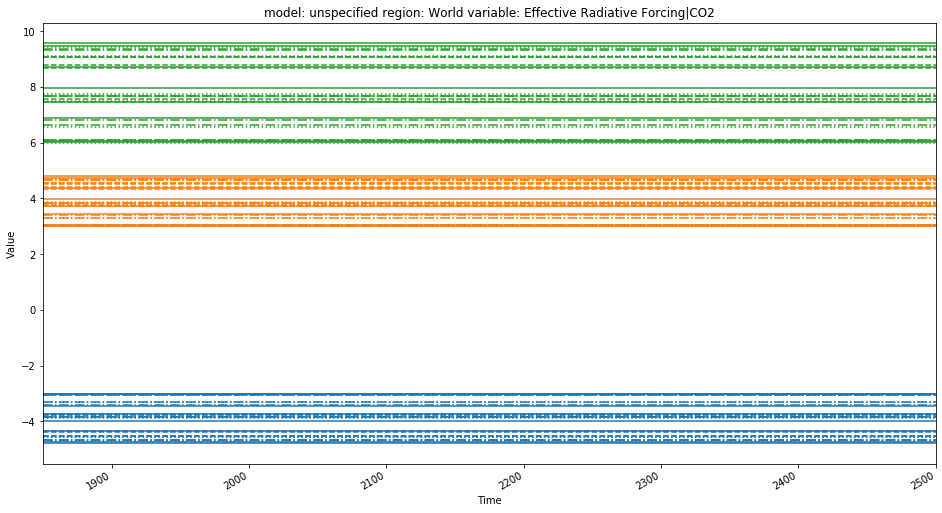

In [14]:
ax = results.filter(scenario="abrupt-*").filter(variable="*Forcing*|CO2").line_plot(
    figsize=(16, 9), linestyle="climatemodel", color="scenario", legend=False
)

(-4, 15)

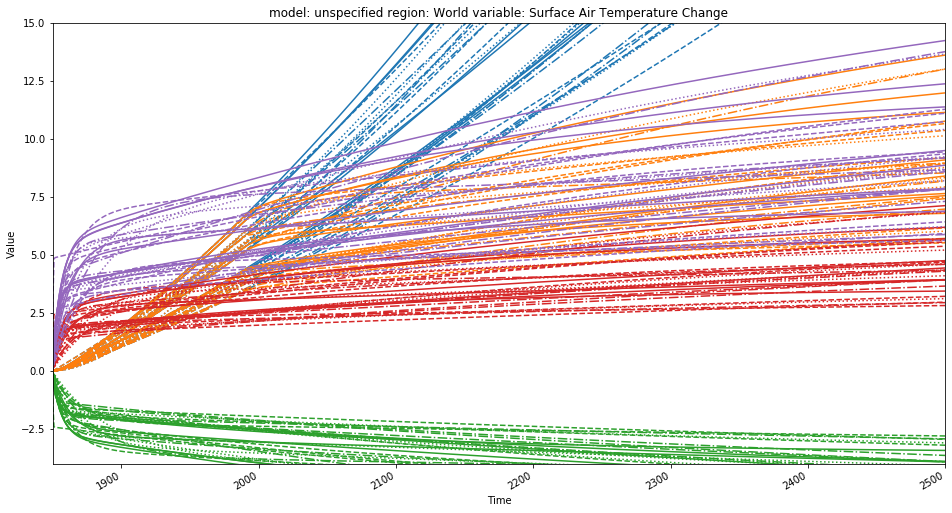

In [15]:
ax = results.filter(scenario=["ssp*", "historical", "piControl"], keep=False).filter(variable="*Temperature*").line_plot(
    figsize=(16, 9), linestyle="climatemodel", color="scenario", legend=False
)
ax.set_ylim([-4, 15])

(-4, 15)

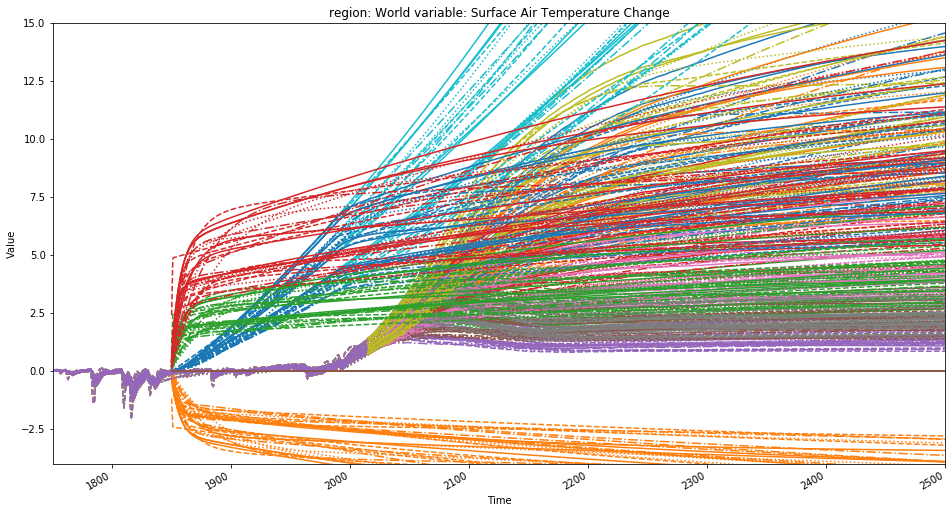

In [16]:
ax = results.filter(variable="*Temperature*").line_plot(
    figsize=(16, 9), linestyle="climatemodel", color="scenario", legend=False
)
ax.set_ylim([-4, 15])

In [17]:
save_scmdf = results.timeseries().unstack("variable").stack("time")
save_scmdf["Effective Radiative Forcing"] = (
    save_scmdf["Effective Radiative Forcing|CO2"]
    + save_scmdf["Effective Radiative Forcing|Non-CO2"]
)
save_scmdf = save_scmdf.unstack("time").stack("variable")

save_scmdf = save_scmdf.reset_index()

def rename_vars(inv):
    if inv == "Effective Radiative Forcing|CO2":
        return "Effective Radiative Forcing|Anthropogenic|CO2"
    
    return inv

save_scmdf["variable"] = save_scmdf["variable"].apply(rename_vars)
save_scmdf = ScmDataFrame(save_scmdf).filter(variable="*Non-CO2", keep=False)
save_scmdf.to_csv("ar5ir-rcmip-phase-1-results.csv")

In [18]:
save_scmdf["variable"].unique()

array(['Surface Air Temperature Change',
       'Effective Radiative Forcing|Anthropogenic|CO2',
       'Atmospheric Concentrations|CO2', 'Effective Radiative Forcing'],
      dtype=object)

In [19]:
save_scmdf.head(1)

,,,,,,,,,time,1750-01-01 00:00:00,1751-01-01 00:00:00,1752-01-01 00:00:00,1753-01-01 00:00:00,1754-01-01 00:00:00,1755-01-01 00:00:00,1756-01-01 00:00:00,1757-01-01 00:00:00,1758-01-01 00:00:00,1759-01-01 00:00:00,...,2491-01-01 00:00:00,2492-01-01 00:00:00,2493-01-01 00:00:00,2494-01-01 00:00:00,2495-01-01 00:00:00,2496-01-01 00:00:00,2497-01-01 00:00:00,2498-01-01 00:00:00,2499-01-01 00:00:00,2500-01-01 00:00:00
model,scenario,region,variable,unit,activity_id,climatemodel,ecs (k),mip_era,tcr (k),,,,,,,,,,,,,,,,,,,,,
AIM,ssp370,World,Surface Air Temperature Change,K,input4MIPs,ar5ir3box-CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB,3.888383,CMIP6,1.920897,0.006917,0.017887,0.023193,0.02322,0.01902,0.011016,-0.011894,-0.033728,-0.032551,-0.018812,...,8.523242,8.525018,8.526779,8.528525,8.530255,8.531974,8.533679,8.535368,8.537044,8.538772


In [20]:
desc = save_scmdf[["climatemodel", "ecs (k)", "tcr (k)"]].drop_duplicates()
desc["name"] = desc["climatemodel"].apply(lambda x: x[:5])
desc["version"] = desc["climatemodel"].apply(lambda x: x[5:9])
desc["config"] = desc["climatemodel"].apply(lambda x: "-".join(x.split("-")[1:]))

desc.to_csv("ar5ir-rcmip-model-desc.csv")
desc

time,climatemodel,ecs (k),tcr (k),name,version,config
0,ar5ir3box-CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB,3.888383,1.920897,ar5ir,3box,CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB
1,ar5ir2box-CMIP6-NorCPM1_r1i1p1f1-CALIB,4.660431,1.658231,ar5ir,2box,CMIP6-NorCPM1_r1i1p1f1-CALIB
2,ar5ir2box-CMIP6-GISS-E2-1-G_r1i1p1f1-CALIB,4.774921,1.645808,ar5ir,2box,CMIP6-GISS-E2-1-G_r1i1p1f1-CALIB
3,ar5ir3box-CMIP6-GISS-E2-1-G_r1i1p1f1-CALIB,4.867692,1.732761,ar5ir,3box,CMIP6-GISS-E2-1-G_r1i1p1f1-CALIB
4,ar5ir3box-CMIP6-GISS-E2-1-H_r1i1p1f1-CALIB,5.640000,1.907890,ar5ir,3box,CMIP6-GISS-E2-1-H_r1i1p1f1-CALIB
5,ar5ir2box-CMIP6-GISS-E2-2-G_r1i1p1f1-CALIB,5.754486,1.578632,ar5ir,2box,CMIP6-GISS-E2-2-G_r1i1p1f1-CALIB
6,ar5ir3box-CMIP6-IPSL-CM6A-LR_r1i1p1f1-CALIB,5.984962,2.567507,ar5ir,3box,CMIP6-IPSL-CM6A-LR_r1i1p1f1-CALIB
7,ar5ir2box-CMIP6-BCC-ESM1_r1i1p1f1-CALIB,6.158267,1.841056,ar5ir,2box,CMIP6-BCC-ESM1_r1i1p1f1-CALIB
8,ar5ir2box-CMIP6-UKESM1-0-LL_r1i1p1f2-CALIB,6.164842,2.779641,ar5ir,2box,CMIP6-UKESM1-0-LL_r1i1p1f2-CALIB
9,ar5ir3box-CMIP6-CNRM-ESM2-1_r1i1p1f2-CALIB,6.606308,2.228383,ar5ir,3box,CMIP6-CNRM-ESM2-1_r1i1p1f2-CALIB
